# Method 5 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

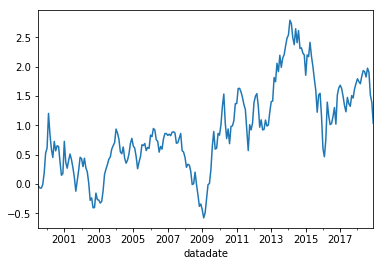

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.525646
2000-12-31   -0.229256
2001-12-31    0.234837
2002-12-31   -0.497196
2003-12-31    1.332019
2004-12-31    0.042533
2005-12-31   -0.095961
2006-12-31    0.158281
2007-12-31   -0.170177
2008-12-31   -0.574391
2009-12-31    1.832463
2010-12-31    0.272885
2011-12-31   -0.138426
2012-12-31    0.090744
2013-12-31    0.566822
2014-12-31   -0.082565
2015-12-31   -0.327691
2016-12-31    0.225401
2017-12-31    0.029188
2018-12-31   -0.250066
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     230.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.28e-79
Time:                        05:26:42   Log-Likelihood:                 342.26
No. Observations:                 234   AIC:                            -674.5
Df Residuals:                     229   BIC:                            -657.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.004      1.688      0.093      -0.001       0.014
mktrf          1.3619      0.106     12.888      0.000       1.154       1.570
me             1.0042      0.123      8.170      0.000       0.762       1.246
ia             0.4084      0.187      2.186      0.030       0.040       0.776
roe           -1.6906      0.160    -10.572      0.000      -2.006      -1.375
==============================================================================
Omnibus:                       72.367   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.633
Skew:                           1.320   Prob(JB):                     9.10e-48
Kurtosis:                       6.904   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     116.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.74e-54
Time:                        05:26:42   Log-Likelihood:                 342.26
No. Observations:                 234   AIC:                            -674.5
Df Residuals:                     229   BIC:                            -657.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.004      1.632      0.103      -0.001       0.014
mktrf          1.3619      0.135     10.089      0.000       1.097       1.626
me             1.0042      0.102      9.857      0.000       0.805       1.204
ia             0.4084      0.206      1.981      0.048       0.004       0.812
roe           -1.6906      0.250     -6.764      0.000      -2.180      -1.201
==============================================================================
Omnibus:                       72.367   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.633
Skew:                           1.320   Prob(JB):                     9.10e-48
Kurtosis:                       6.904   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     154.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.02e-63
Time:                        05:26:42   Log-Likelihood:                 342.26
No. Observations:                 234   AIC:                            -674.5
Df Residuals:                     229   BIC:                            -657.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.004      1.514      0.130      -0.002       0.015
mktrf          1.3619      0.119     11.485      0.000       1.129       1.594
me             1.0042      0.115      8.728      0.000       0.779       1.230
ia             0.4084      0.199      2.049      0.041       0.018       0.799
roe           -1.6906      0.238     -7.118      0.000      -2.156      -1.225
==============================================================================
Omnibus:                       72.367   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.633
Skew:                           1.320   Prob(JB):                     9.10e-48
Kurtosis:                       6.904   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     154.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.13e-71
Time:                        05:26:42   Log-Likelihood:                 326.47
No. Observations:                 234   AIC:                            -640.9
Df Residuals:                     228   BIC:                            -620.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.126      0.261      -0.004       0.013
mktrf          1.5400      0.114     13.567      0.000       1.316       1.764
smb            1.1080      0.150      7.398      0.000       0.813       1.403
hml            0.7272      0.177      4.118      0.000       0.379       1.075
rmw           -1.3965      0.200     -6.994      0.000      -1.790      -1.003
cma           -0.0315      0.254     -0.124      0.901      -0.532       0.469
==============================================================================
Omnibus:                      105.186   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.015
Skew:                           1.779   Prob(JB):                    3.93e-107
Kurtosis:                       9.132   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     125.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.90e-63
Time:                        05:26:42   Log-Likelihood:                 326.47
No. Observations:                 234   AIC:                            -640.9
Df Residuals:                     228   BIC:                            -620.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.005      0.952      0.341      -0.005       0.014
mktrf          1.5400      0.103     14.996      0.000       1.339       1.741
smb            1.1080      0.135      8.234      0.000       0.844       1.372
hml            0.7272      0.228      3.189      0.001       0.280       1.174
rmw           -1.3965      0.217     -6.433      0.000      -1.822      -0.971
cma           -0.0315      0.341     -0.092      0.926      -0.701       0.638
==============================================================================
Omnibus:                      105.186   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.015
Skew:                           1.779   Prob(JB):                    3.93e-107
Kurtosis:                       9.132   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     156.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.04e-71
Time:                        05:26:42   Log-Likelihood:                 326.47
No. Observations:                 234   AIC:                            -640.9
Df Residuals:                     228   BIC:                            -620.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.006      0.849      0.396      -0.006       0.016
mktrf          1.5400      0.090     17.198      0.000       1.364       1.715
smb            1.1080      0.130      8.543      0.000       0.854       1.362
hml            0.7272      0.186      3.907      0.000       0.362       1.092
rmw           -1.3965      0.202     -6.897      0.000      -1.793      -1.000
cma           -0.0315      0.331     -0.095      0.924      -0.681       0.618
==============================================================================
Omnibus:                      105.186   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.015
Skew:                           1.779   Prob(JB):                    3.93e-107
Kurtosis:                       9.132   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     211.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.34e-75
Time:                        05:26:42   Log-Likelihood:                 334.01
No. Observations:                 234   AIC:                            -658.0
Df Residuals:                     229   BIC:                            -640.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.004      0.345      0.730      -0.006       0.009
mktrf          1.5815      0.101     15.693      0.000       1.383       1.780
smb            1.7764      0.126     14.122      0.000       1.529       2.024
hml            0.3960      0.125      3.169      0.002       0.150       0.642
umd           -0.6558      0.082     -7.998      0.000      -0.817      -0.494
==============================================================================
Omnibus:                       66.113   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.582
Skew:                           1.175   Prob(JB):                     3.09e-46
Kurtosis:                       6.996   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     98.96
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.93e-49
Time:                        05:26:43   Log-Likelihood:                 334.01
No. Observations:                 234   AIC:                            -658.0
Df Residuals:                     229   BIC:                            -640.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.004      0.363      0.717      -0.006       0.009
mktrf          1.5815      0.127     12.474      0.000       1.333       1.830
smb            1.7764      0.160     11.107      0.000       1.463       2.090
hml            0.3960      0.153      2.596      0.009       0.097       0.695
umd           -0.6558      0.129     -5.101      0.000      -0.908      -0.404
==============================================================================
Omnibus:                       66.113   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.582
Skew:                           1.175   Prob(JB):                     3.09e-46
Kurtosis:                       6.996   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     116.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.26e-54
Time:                        05:26:43   Log-Likelihood:                 334.01
No. Observations:                 234   AIC:                            -658.0
Df Residuals:                     229   BIC:                            -640.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.004      0.349      0.727      -0.006       0.009
mktrf          1.5815      0.110     14.436      0.000       1.367       1.796
smb            1.7764      0.158     11.210      0.000       1.466       2.087
hml            0.3960      0.149      2.657      0.008       0.104       0.688
umd           -0.6558      0.109     -6.031      0.000      -0.869      -0.443
==============================================================================
Omnibus:                       66.113   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.582
Skew:                           1.175   Prob(JB):                     3.09e-46
Kurtosis:                       6.996   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     125.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.40e-41
Time:                        05:26:43   Log-Likelihood:                 165.13
No. Observations:                 120   AIC:                            -320.3
Df Residuals:                     115   BIC:                            -306.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.006      2.163      0.033       0.001       0.025
mktrf          1.2965      0.161      8.058      0.000       0.978       1.615
me             0.9551      0.159      6.010      0.000       0.640       1.270
ia             0.1084      0.249      0.436      0.664      -0.385       0.601
roe           -1.5499      0.220     -7.036      0.000      -1.986      -1.114
==============================================================================
Omnibus:                       27.419   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.689
Skew:                           1.005   Prob(JB):                     2.67e-11
Kurtosis:                       5.387   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     94.79
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-35
Time:                        05:26:43   Log-Likelihood:                 165.13
No. Observations:                 120   AIC:                            -320.3
Df Residuals:                     115   BIC:                            -306.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.006      2.103      0.035       0.001       0.025
mktrf          1.2965      0.191      6.790      0.000       0.922       1.671
me             0.9551      0.113      8.471      0.000       0.734       1.176
ia             0.1084      0.244      0.443      0.657      -0.371       0.587
roe           -1.5499      0.258     -6.002      0.000      -2.056      -1.044
==============================================================================
Omnibus:                       27.419   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.689
Skew:                           1.005   Prob(JB):                     2.67e-11
Kurtosis:                       5.387   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     148.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.95e-44
Time:                        05:26:43   Log-Likelihood:                 165.13
No. Observations:                 120   AIC:                            -320.3
Df Residuals:                     115   BIC:                            -306.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.007      1.930      0.054      -0.000       0.026
mktrf          1.2965      0.153      8.479      0.000       0.997       1.596
me             0.9551      0.131      7.304      0.000       0.699       1.211
ia             0.1084      0.223      0.487      0.626      -0.328       0.545
roe           -1.5499      0.216     -7.188      0.000      -1.972      -1.127
==============================================================================
Omnibus:                       27.419   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.689
Skew:                           1.005   Prob(JB):                     2.67e-11
Kurtosis:                       5.387   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     83.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.88e-36
Time:                        05:26:43   Log-Likelihood:                 156.69
No. Observations:                 120   AIC:                            -301.4
Df Residuals:                     114   BIC:                            -284.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.007      1.923      0.057      -0.000       0.026
mktrf          1.5933      0.183      8.714      0.000       1.231       1.956
smb            1.1126      0.207      5.373      0.000       0.702       1.523
hml            0.4536      0.254      1.788      0.076      -0.049       0.956
rmw           -1.1862      0.299     -3.964      0.000      -1.779      -0.593
cma           -0.0519      0.328     -0.158      0.874      -0.701       0.597
==============================================================================
Omnibus:                       57.598   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.212
Skew:                           1.772   Prob(JB):                     1.35e-41
Kurtosis:                       8.009   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     69.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.58e-33
Time:                        05:26:43   Log-Likelihood:                 156.69
No. Observations:                 120   AIC:                            -301.4
Df Residuals:                     114   BIC:                            -284.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.007      1.805      0.071      -0.001       0.026
mktrf          1.5933      0.186      8.553      0.000       1.228       1.958
smb            1.1126      0.184      6.044      0.000       0.752       1.473
hml            0.4536      0.197      2.299      0.022       0.067       0.840
rmw           -1.1862      0.271     -4.383      0.000      -1.717      -0.656
cma           -0.0519      0.406     -0.128      0.898      -0.847       0.743
==============================================================================
Omnibus:                       57.598   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.212
Skew:                           1.772   Prob(JB):                     1.35e-41
Kurtosis:                       8.009   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     103.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.23e-40
Time:                        05:26:43   Log-Likelihood:                 156.69
No. Observations:                 120   AIC:                            -301.4
Df Residuals:                     114   BIC:                            -284.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.008      1.581      0.114      -0.003       0.028
mktrf          1.5933      0.158     10.088      0.000       1.284       1.903
smb            1.1126      0.172      6.482      0.000       0.776       1.449
hml            0.4536      0.164      2.758      0.006       0.131       0.776
rmw           -1.1862      0.265     -4.473      0.000      -1.706      -0.666
cma           -0.0519      0.388     -0.134      0.893      -0.812       0.708
==============================================================================
Omnibus:                       57.598   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.212
Skew:                           1.772   Prob(JB):                     1.35e-41
Kurtosis:                       8.009   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     129.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-41
Time:                        05:26:43   Log-Likelihood:                 166.71
No. Observations:                 120   AIC:                            -323.4
Df Residuals:                     115   BIC:                            -309.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.006      1.357      0.177      -0.004       0.019
mktrf          1.5868      0.140     11.342      0.000       1.310       1.864
smb            1.7665      0.159     11.090      0.000       1.451       2.082
hml            0.1604      0.160      1.006      0.317      -0.156       0.476
umd           -0.6303      0.098     -6.408      0.000      -0.825      -0.435
==============================================================================
Omnibus:                       17.815   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.436
Skew:                           0.751   Prob(JB):                     3.00e-06
Kurtosis:                       4.683   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     74.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.52e-31
Time:                        05:26:43   Log-Likelihood:                 166.71
No. Observations:                 120   AIC:                            -323.4
Df Residuals:                     115   BIC:                            -309.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.005      1.427      0.153      -0.003       0.019
mktrf          1.5868      0.188      8.420      0.000       1.217       1.956
smb            1.7665      0.181      9.767      0.000       1.412       2.121
hml            0.1604      0.156      1.029      0.303      -0.145       0.466
umd           -0.6303      0.138     -4.584      0.000      -0.900      -0.361
==============================================================================
Omnibus:                       17.815   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.436
Skew:                           0.751   Prob(JB):                     3.00e-06
Kurtosis:                       4.683   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     90.74
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-34
Time:                        05:26:43   Log-Likelihood:                 166.71
No. Observations:                 120   AIC:                            -323.4
Df Residuals:                     115   BIC:                            -309.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.006      1.384      0.166      -0.003       0.019
mktrf          1.5868      0.159     10.000      0.000       1.276       1.898
smb            1.7665      0.160     11.019      0.000       1.452       2.081
hml            0.1604      0.138      1.160      0.246      -0.111       0.432
umd           -0.6303      0.112     -5.610      0.000      -0.851      -0.410
==============================================================================
Omnibus:                       17.815   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.436
Skew:                           0.751   Prob(JB):                     3.00e-06
Kurtosis:                       4.683   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     115.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.82e-38
Time:                        05:26:43   Log-Likelihood:                 187.95
No. Observations:                 114   AIC:                            -365.9
Df Residuals:                     109   BIC:                            -352.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.254e-05      0.005     -0.015      0.988      -0.009       0.009
mktrf          1.4989      0.140     10.714      0.000       1.222       1.776
me             0.9271      0.216      4.292      0.000       0.499       1.355
ia             0.7562      0.300      2.524      0.013       0.162       1.350
roe           -2.2485      0.263     -8.540      0.000      -2.770      -1.727
==============================================================================
Omnibus:                       32.510   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.024
Skew:                           1.161   Prob(JB):                     4.60e-15
Kurtosis:                       5.916   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     92.86
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.35e-34
Time:                        05:26:43   Log-Likelihood:                 187.95
No. Observations:                 114   AIC:                            -365.9
Df Residuals:                     109   BIC:                            -352.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.254e-05      0.004     -0.020      0.984      -0.007       0.007
mktrf          1.4989      0.130     11.504      0.000       1.244       1.754
me             0.9271      0.257      3.606      0.000       0.423       1.431
ia             0.7562      0.295      2.564      0.010       0.178       1.334
roe           -2.2485      0.500     -4.495      0.000      -3.229      -1.268
==============================================================================
Omnibus:                       32.510   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.024
Skew:                           1.161   Prob(JB):                     4.60e-15
Kurtosis:                       5.916   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     102.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.52e-36
Time:                        05:26:43   Log-Likelihood:                 187.95
No. Observations:                 114   AIC:                            -365.9
Df Residuals:                     109   BIC:                            -352.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.254e-05      0.003     -0.024      0.981      -0.006       0.006
mktrf          1.4989      0.118     12.665      0.000       1.267       1.731
me             0.9271      0.296      3.137      0.002       0.348       1.506
ia             0.7562      0.272      2.783      0.005       0.224       1.289
roe           -2.2485      0.503     -4.472      0.000      -3.234      -1.263
==============================================================================
Omnibus:                       32.510   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.024
Skew:                           1.161   Prob(JB):                     4.60e-15
Kurtosis:                       5.916   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     75.25
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.38e-33
Time:                        05:26:43   Log-Likelihood:                 179.07
No. Observations:                 114   AIC:                            -346.1
Df Residuals:                     108   BIC:                            -329.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.005     -0.764      0.446      -0.014       0.006
mktrf          1.5970      0.145     11.020      0.000       1.310       1.884
smb            0.9868      0.235      4.195      0.000       0.521       1.453
hml            1.1490      0.300      3.829      0.000       0.554       1.744
rmw           -1.4621      0.367     -3.980      0.000      -2.190      -0.734
cma            0.0050      0.466      0.011      0.991      -0.919       0.929
==============================================================================
Omnibus:                       42.886   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.261
Skew:                           1.221   Prob(JB):                     2.90e-37
Kurtosis:                       8.427   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     67.34
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-31
Time:                        05:26:43   Log-Likelihood:                 179.07
No. Observations:                 114   AIC:                            -346.1
Df Residuals:                     108   BIC:                            -329.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.005     -0.760      0.447      -0.014       0.006
mktrf          1.5970      0.124     12.873      0.000       1.354       1.840
smb            0.9868      0.206      4.794      0.000       0.583       1.390
hml            1.1490      0.303      3.796      0.000       0.556       1.742
rmw           -1.4621      0.466     -3.139      0.002      -2.375      -0.549
cma            0.0050      0.390      0.013      0.990      -0.759       0.769
==============================================================================
Omnibus:                       42.886   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.261
Skew:                           1.221   Prob(JB):                     2.90e-37
Kurtosis:                       8.427   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     67.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-31
Time:                        05:26:43   Log-Likelihood:                 179.07
No. Observations:                 114   AIC:                            -346.1
Df Residuals:                     108   BIC:                            -329.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.005     -0.772      0.440      -0.014       0.006
mktrf          1.5970      0.132     12.091      0.000       1.338       1.856
smb            0.9868      0.232      4.246      0.000       0.531       1.442
hml            1.1490      0.280      4.104      0.000       0.600       1.698
rmw           -1.4621      0.457     -3.197      0.001      -2.359      -0.566
cma            0.0050      0.377      0.013      0.989      -0.733       0.743
==============================================================================
Omnibus:                       42.886   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.261
Skew:                           1.221   Prob(JB):                     2.90e-37
Kurtosis:                       8.427   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     91.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.04e-34
Time:                        05:26:43   Log-Likelihood:                 177.31
No. Observations:                 114   AIC:                            -344.6
Df Residuals:                     109   BIC:                            -330.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.005     -0.846      0.399      -0.015       0.006
mktrf          1.6221      0.146     11.144      0.000       1.334       1.911
smb            1.3347      0.227      5.881      0.000       0.885       1.785
hml            1.0874      0.234      4.652      0.000       0.624       1.551
umd           -0.6570      0.176     -3.726      0.000      -1.006      -0.308
==============================================================================
Omnibus:                       48.904   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.621
Skew:                           1.337   Prob(JB):                     4.15e-52
Kurtosis:                       9.532   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     92.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.05e-34
Time:                        05:26:43   Log-Likelihood:                 177.31
No. Observations:                 114   AIC:                            -344.6
Df Residuals:                     109   BIC:                            -330.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.004     -1.027      0.304      -0.013       0.004
mktrf          1.6221      0.131     12.338      0.000       1.364       1.880
smb            1.3347      0.210      6.352      0.000       0.923       1.747
hml            1.0874      0.241      4.512      0.000       0.615       1.560
umd           -0.6570      0.144     -4.565      0.000      -0.939      -0.375
==============================================================================
Omnibus:                       48.904   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.621
Skew:                           1.337   Prob(JB):                     4.15e-52
Kurtosis:                       9.532   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     106.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-36
Time:                        05:26:43   Log-Likelihood:                 177.31
No. Observations:                 114   AIC:                            -344.6
Df Residuals:                     109   BIC:                            -330.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.004     -1.030      0.303      -0.013       0.004
mktrf          1.6221      0.128     12.655      0.000       1.371       1.873
smb            1.3347      0.189      7.057      0.000       0.964       1.705
hml            1.0874      0.238      4.574      0.000       0.621       1.553
umd           -0.6570      0.134     -4.910      0.000      -0.919      -0.395
==============================================================================
Omnibus:                       48.904   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.621
Skew:                           1.337   Prob(JB):                     4.15e-52
Kurtosis:                       9.532   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""